In [1]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet34
from torchvision.models import ResNet34_Weights
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
import os
import pandas as pd

1) PREPROCESS IMAGES

Preprocess the extra images obtained from Prof. Souza by creating a new square image with side length equal to the length of the longest side of the original image, then calculating the margin from the top left corner to displace the original image. Paste the original image on top of the new square image to obtain the final image with lengths of equal size. Finally, resize that image to 512 x 512 x 3 and save it to a new folder as a jpg.

In [2]:
def add_margin(height, width, pil_image, top, right, bottom, left, color):
    
    new_width = width + right + left
    new_height = height + top + bottom
    # create a new image with new_width, new_height dimensions in the
    # same mode as the original image
    result = Image.new(pil_image.mode, (new_width, new_height), color)
    # paste the original image onto the new black image displaced from
    # the left and top by the specified number of pixels
    result.paste(pil_image, (left, top))
    return result

def keep_AR(image):
    
    target_aspect_ratio = 1
    original_width = image.width
    original_height = image.height
    current_aspect_ratio = original_width / original_height
    new_image = []
    
    if current_aspect_ratio == target_aspect_ratio:
        new_image = image
    if current_aspect_ratio < target_aspect_ratio:
        # need to increase width
        target_width = int(target_aspect_ratio * original_height)
        pad_amount_pixels = target_width - original_width
        new_image = add_margin(original_height, original_width, image, 0, int(pad_amount_pixels/2), 0, int(pad_amount_pixels/2), (0, 0, 0))
    if current_aspect_ratio > target_aspect_ratio:
        # need to increase height
        target_height = int(original_width/target_aspect_ratio)
        pad_amount_pixels = target_height - original_height
        new_image = add_margin(original_height, original_width, image, int(pad_amount_pixels/2), 0, int(pad_amount_pixels/2), 0, (0, 0, 0))

    return new_image
        
def resize(class_):
    # path to the folder with the class folders, black, blue, green, other
    path = "..\\dataset\\" + class_
    # get list of all image names
    dirs = os.listdir(path)
    count = 0
    # new folder name with resized images
    resized_path = class_ + "_resized"
    for item in dirs:
        print(path + "\\" + item)
        if os.path.isfile(path + "\\" + item):
            try:
                image = Image.open(path + "\\" + item)
                # calculate what margin to add to the left/right or top/bottom
                # and then create a new image, paste the original image onto the new
                # image displaced by the left/right and top/bottom margins
                image = keep_AR(image)
                image_resized = image.resize((512, 512), Image.ANTIALIAS)
                if not os.path.exists("..\\dataset\\" + resized_path + "\\"):
                    os.mkdir("..\\dataset\\" + resized_path + "\\")
                image_resized.convert("RGB").save(f"..\\dataset\\" + resized_path + "\\" + class_ + "_" + str(count) + "_rgba.jpg")
                count += 1
            except Exception as e:
                print(e)
            

In [3]:
# Preprocess the extra data obtained from Prof Souza to 512 x 512 x 3 jpg images
resize_images = False
if resize_images:
    resize("black")
    resize("blue")
    resize("green")
    resize("other")

2) Load the dataset

In [4]:
filepath_to_dataset = "C:\\Users\\lingl\\OneDrive\Desktop\\ENEL_645\\Assignments\\finalproject\\images\\"

image_paths = glob.glob(filepath_to_dataset + "*\\*.jpg")

# full path to each image
image_paths = np.array(image_paths)

# labels for each image as a string
labels_string = np.array([f.split("\\")[-2] for f in image_paths])

print(f"Number of images is {len(image_paths)}")
print(f"Number of labels is {len(labels_string)}")
print(f"Example image_path is {image_paths[0]}")
print(f"Example label is {labels_string[0]}")

# unqiue class names
classes = np.unique(labels_string).flatten()
print(f"Classes are {classes}")

# convert our labels_string vector to a integer vector
labels_int = np.zeros(labels_string.size, dtype=np.int64)
for index, class_name in enumerate(classes):
    labels_int[labels_string == class_name] = index

Number of images is 20584
Number of labels is 20584
Example image_path is C:\Users\lingl\OneDrive\Desktop\ENEL_645\Assignments\finalproject\images\Black\0.jpg
Example label is Black
Classes are ['Black' 'Blue' 'Green' 'Other']


3) EDA

Text(0.5, 1.0, 'Distribution of samples')

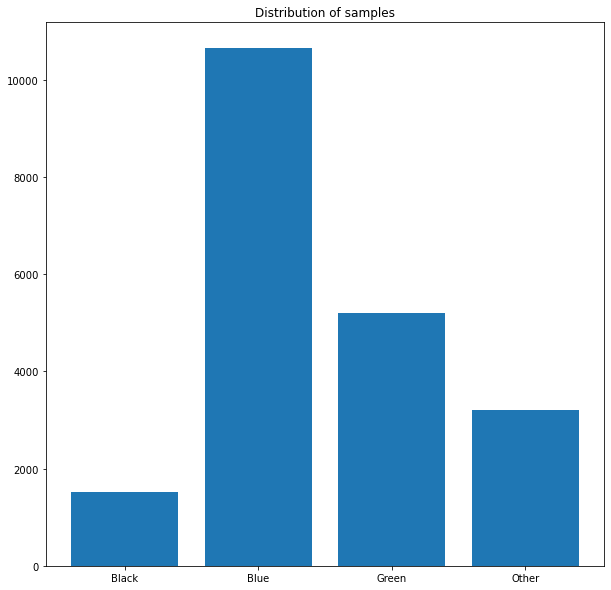

In [5]:
# plot the distribution of the classes 
plt.figure(figsize=(10, 10))
df = pd.DataFrame(labels_int, columns=["Class"])
class_counts = df["Class"].value_counts().sort_index()
plt.bar(classes, class_counts.values)
plt.title("Distribution of samples")

4) Split into train, val, test

In [6]:
# split image_paths and labels_int into development and test set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
sss.get_n_splits(image_paths, labels_int)
dev_index, test_index = next(sss.split(image_paths, labels_int))

dev_image_paths = image_paths[dev_index]
dev_labels_int = labels_int[dev_index]

test_image_paths =  image_paths[test_index]
test_labels_int = labels_int[test_index]

# split dev_image_paths and dev_labels_int into validation and training set
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
sss2.get_n_splits(dev_image_paths, dev_labels_int)
train_index, val_index = next(sss.split(dev_image_paths, dev_labels_int))

train_image_paths = dev_image_paths[train_index]
train_labels_int = dev_labels_int[train_index]

val_image_paths = dev_image_paths[val_index]
val_labels_int = dev_labels_int[val_index]

print(f"Train set")
print(f"Images size {train_image_paths.size}")
print(f"Labels size is {train_labels_int.size}")
print()
print(f"Validation set")
print(f"Images size {val_image_paths.size}")
print(f"Labels size is {val_labels_int.size}")
print()
print(f"Test set")
print(f"Images size {test_image_paths.size}")
print(f"Labels size is {test_labels_int.size}")
print()

Train set
Images size 13173
Labels size is 13173

Validation set
Images size 3294
Labels size is 3294

Test set
Images size 4117
Labels size is 4117



5) EDA

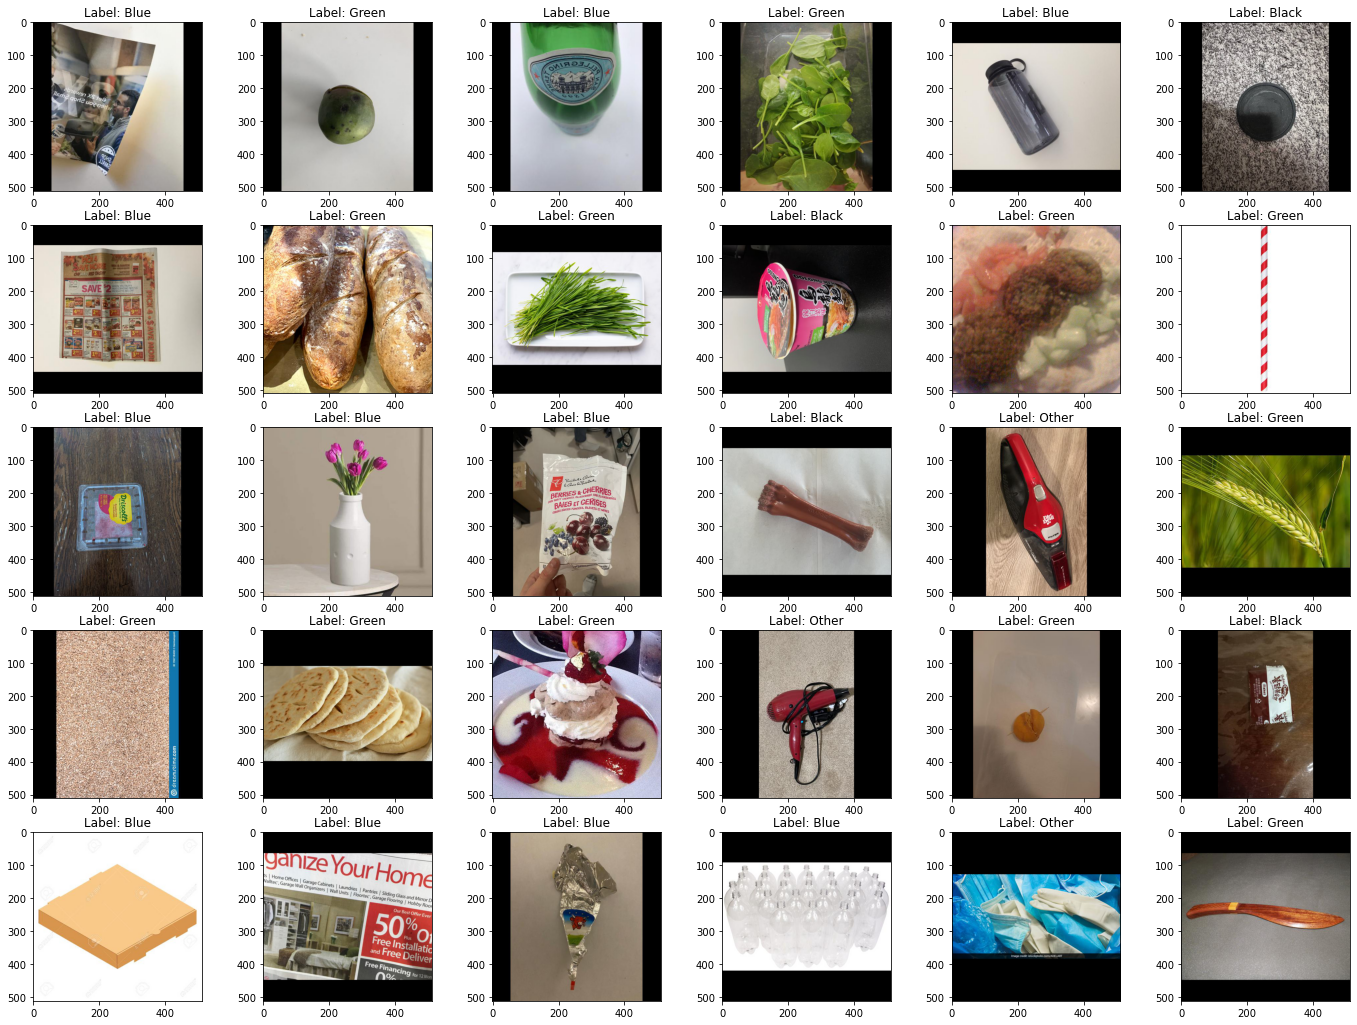

In [7]:
# displaying some samples from the training set
sample_indexes = np.random.choice(np.arange(train_image_paths.shape[0], dtype=int), size=30, replace=False)
plt.figure(figsize=(24,18))
for (index, sample_index) in enumerate(sample_indexes):
    plt.subplot(5, 6, index+1)
    plt.imshow(Image.open(train_image_paths[sample_index]))
    plt.title(f"Label: {classes[train_labels_int[sample_index]]}")
plt.show()

6) Define Dataset class and DataLoaders

In [8]:
class TorchVisionDataset(Dataset):
    
    def __init__(self, data_dic, transform=None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        image = Image.open(file_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
# define dictionaries for each set with X as the filepaths and y as the labels
train_set = {
    "X": train_image_paths,
    "Y": train_labels_int
}

val_set = {
    "X": val_image_paths,
    "Y": val_labels_int
}

test_set = {
    "X": test_image_paths,
    "Y": test_labels_int
}

In [10]:
# define a function to calculate the mean and std for each channel of the images in the train set
def get_dataset_stats(dataset_image_paths):
    mean = 0
    std = 0
    nb_samples = 0
    for image_path in dataset_image_paths:
        # get the image to compute the statistics
        image = np.array(Image.open(image_path))
        image = image / 255
        mean += np.mean(image, axis=(0, 1))
        std += np.std(image, axis=(0, 1))
        nb_samples += 1
        
    mean /= nb_samples
    std /= nb_samples

    return mean, std

get_train_stats = False
if get_train_stats:
    train_set_means, train_set_stds = get_dataset_stats(train_image_paths)

    print(f"The means for the RGB channels in the train set is \n{train_set_means}")
    print(f"The stds for the RGB channels in the train set is \n{train_set_stds}")

In [11]:
# define the transforms for the train and validation set for the data loader
torchvision_transforms_train_val = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((0, 180)),
    transforms.ToTensor(),
    ResNet34_Weights.IMAGENET1K_V1.transforms() # apply the same transforms that the original model does
])

# define the transforms for the test set for the data loader
torchvision_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    ResNet34_Weights.IMAGENET1K_V1.transforms() # apply the same transforms that the original model does
])

In [12]:
# create a dataset for train, val and test
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transforms_train_val)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transforms_train_val)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transforms_test)

In [13]:
# create the data loaders for train, val and test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

7) View some sample augmented images from train set

In [16]:
# displaying some samples from the training set from the DataLoader
train_iterator = iter(train_loader)
train_batch = next(train_iterator)

print("Train batch samples shape")
print(f"{train_batch[0].size()}")
print("Train batch labels shape")
print(f"{train_batch[1].size()}")

Train batch samples shape
torch.Size([32, 3, 224, 224])
Train batch labels shape
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

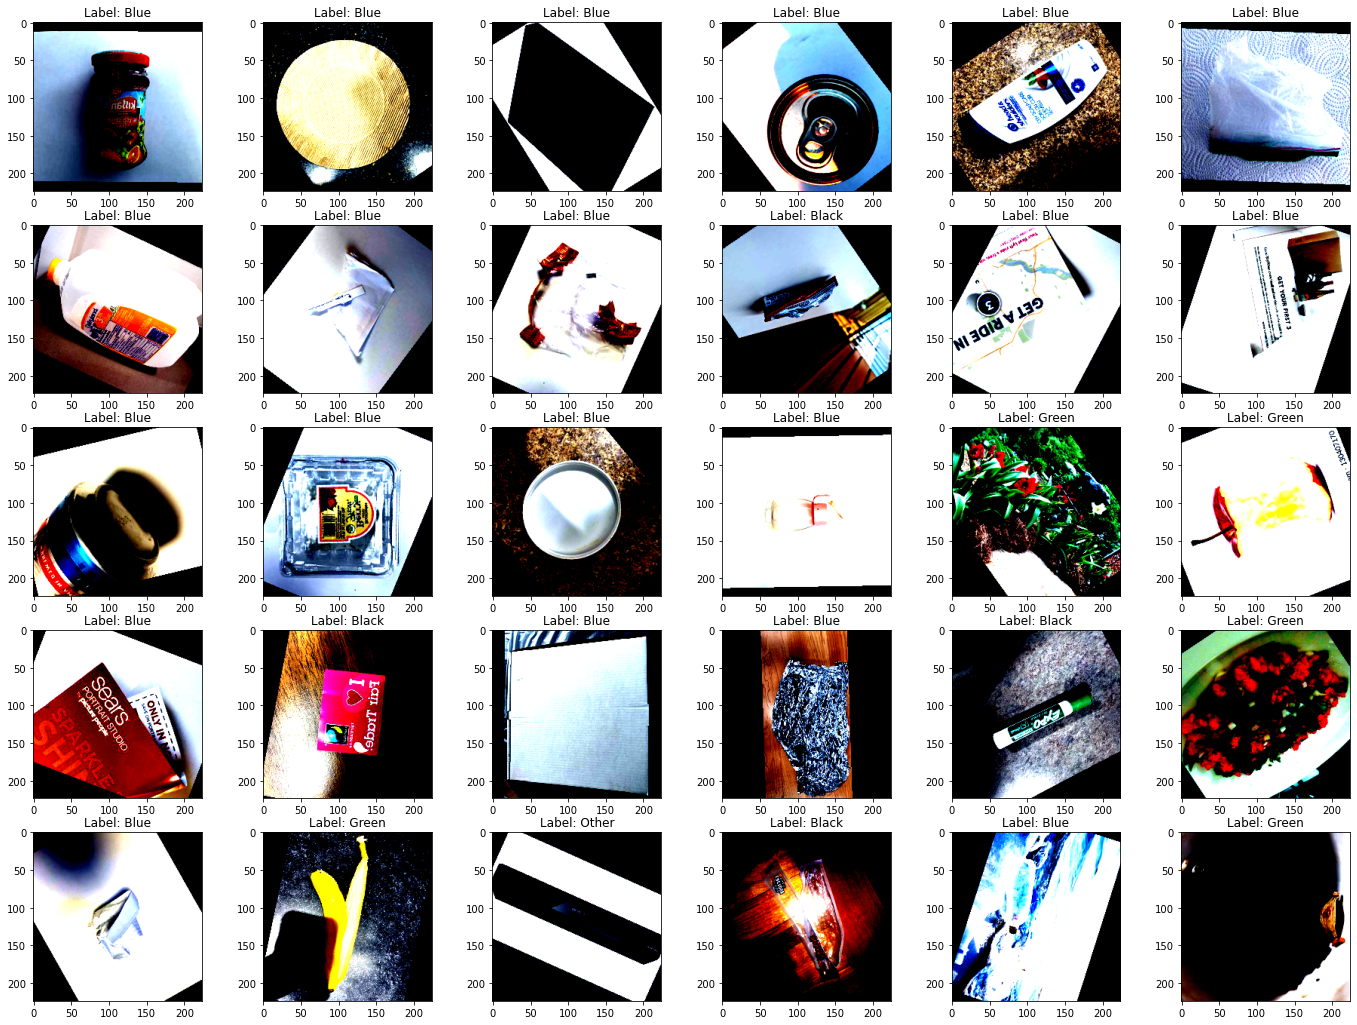

In [18]:
# sample_indexes = np.random.choice(np.arange(train_image_paths.shape[0], dtype=int), size=30, replace=False)
plt.figure(figsize=(24,18))
for (index, sample) in enumerate(train_batch[0][:-2]):
    plt.subplot(5, 6, index+1)
    plt.imshow(sample.numpy().transpose(1, 2, 0))
    plt.title(f"Label: {classes[train_batch[1][index]]}")
plt.show()

8) Define our neural network

In [29]:
class GarbageModel(nn.Module):
    
    def __init__(self, num_classes, input_shape, transfer=True):
        
        super().__init__()
        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if pretrained=True
        self.base_model = models.resnet34(pretrained=transfer)
        
        if self.transfer:
            # freeze layers using eval()
            self.base_model.eval()
            
            for param in self.base_model.parameters():
                param.requires_grad = False
                
        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)
        
    def _get_conv_output(self, shape):
        
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.base_model(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
    def forward(self, x):
        
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [30]:
# check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [33]:
# create our neural network model and send to device
net = GarbageModel(4, (3, 224, 224), True)
net.to(device)

GarbageModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [34]:
# define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [36]:
# training loop
nepochs = 1
PATH = "./garbage_net.pth" # save path for the best model

best_loss = 1e+20
for epoch in range(nepochs):  # epoch loop
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0): # batch loop
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 0.636, val loss: 0.736
Saving model
Finished Training


In [37]:
# Load the best model, unfreeze the base_model, train for a few epochs
net = GarbageModel(4, (3, 224, 224), True)
net.load_state_dict(torch.load(PATH))
net.to(device)

# unfreeze the base_model
for param in net.base_model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr = 1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)

nepochs = 1
PATH = "./garbage_net.pth" # save path for the best model

best_loss = 1e+20
for epoch in range(nepochs):  # epoch loop
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0): # batch loop
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

C:\Users\lingl\anaconda3\envs\ensf-ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lingl\anaconda3\envs\ensf-ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
# Load the best model to be used in the test set
net = GarbageModel(4, (3, 224, 224), True)
net.load_state_dict(torch.load(PATH))

In [ ]:
correct = 0
total = 0

predicted_class = []
actual_class = []
image = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Display some incorrect predictions

        if (predicted != labels).sum().item() > 0:
            incorrect_images = images[predicted != labels]
            incorrect_labels = labels[predicted != labels]
            incorrect_predicted = predicted[predicted != labels]
            
            plt.figure()
            plt.imshow(incorrect_images[0].numpy().transpose(1, 2, 0))
            plt.title(f"Label: {classes[incorrect_labels[0]]}, Predicted: {classes[incorrect_predicted[0]]}")            

print(f'Accuracy of the network on the test images: {100 * correct / total} %')